Data Uploading

In [ ]:
from google.colab import files
uploaded = files.upload()

Loading Data

In [9]:
import pandas as pd
raw_data=pd.read_csv("Material Strength Predictor data.csv")
raw_data.head()

# Rename columns for readability
raw_data.columns = (
    raw_data.columns
    .str.strip()               # remove leading/trailing spaces
    .str.replace(r'\(.*?\)', '', regex=True)  # remove text inside parentheses
    .str.replace('[^A-Za-z0-9]+', '_', regex=True)  # replace non-alphanumeric chars with _
    .str.strip('_')            # remove leading/trailing underscores
)

# (capitalize first letters)
raw_data.columns = [col.capitalize() for col in raw_data.columns]
print(raw_data.columns)

Index(['Cement', 'Blast_furnace_slag', 'Fly_ash', 'Water', 'Superplasticizer',
       'Coarse_aggregate', 'Fine_aggregate', 'Age',
       'Concrete_compressive_strength'],
      dtype='object')


# Exploratory Data Analysis (EDA) – Material Strength Prediction

## Objective
The goal of this notebook is to explore the dataset to understand relationships between features and the target variable, identify patterns, and highlight important trends for predictive modeling.

EDA helps us to:
- Detect relationships between material composition, curing age, and strength
- Identify trends and patterns that are physically meaningful
- Highlight potential feature engineering opportunities
- Detect outliers or unusual data points that may affect model performance

By combining **visual exploration** and **statistical summaries**, we gain a deeper understanding of the dataset and its physical interpretation.


## Feature Distributions:  
We visualize the distribution of each input variable and the target variable to understand the data range, central tendency, and spread. This helps identify potential outliers, skewness, or unusual values that could impact model performance.



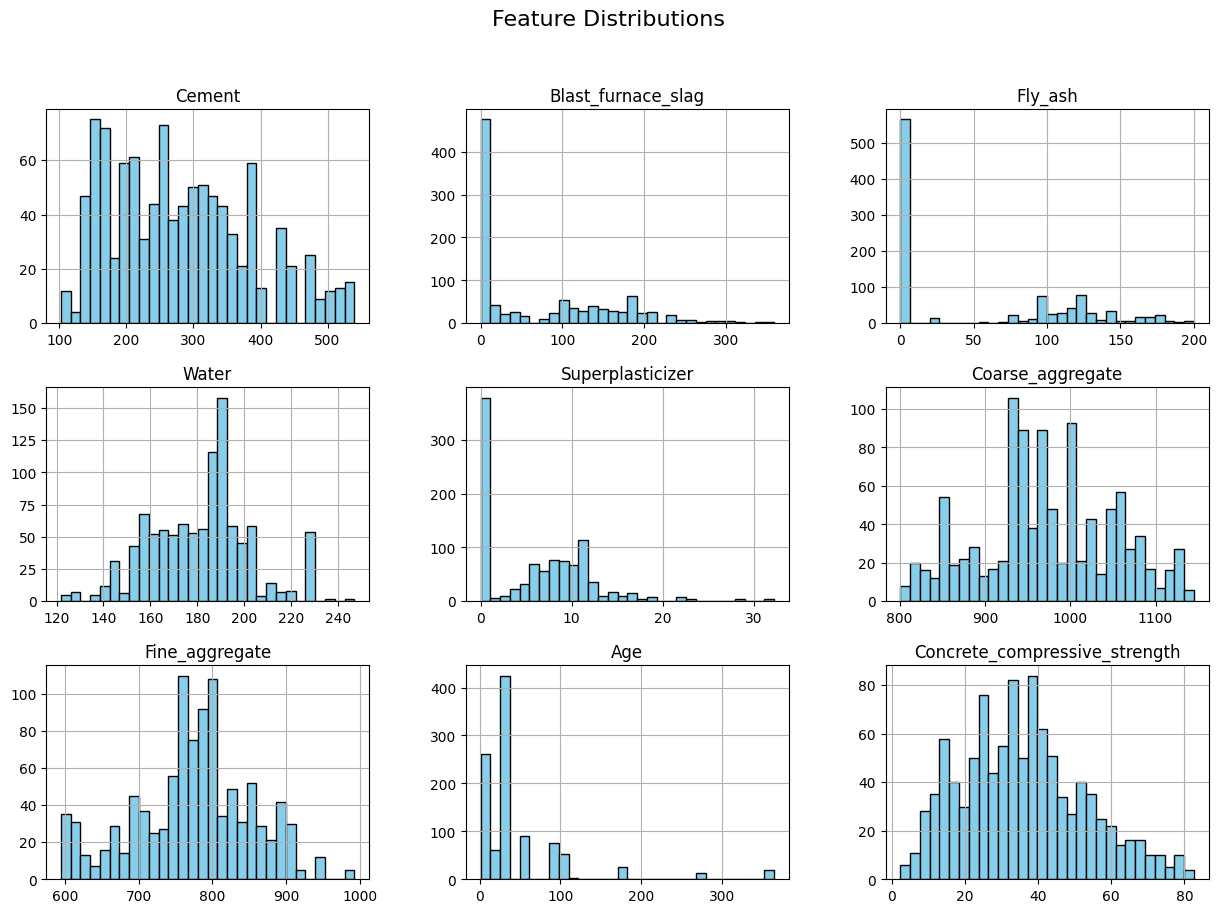

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
raw_data.hist(bins=30, figsize=(15,10), color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

This analysis helps understand how the concrete ingredients and strength values are spread in the dataset. Core materials like water and aggregates are used consistently, while additives such as slag and fly ash are optional and often not included. Most strength tests are done at early curing ages, and the strength values cover a wide range.

## Feature Correlation Heatmap:  
This heatmap shows how strongly each input feature is correlated with others and with the target (compressive strength). High correlations can indicate redundancy between features or key drivers of concrete strength.


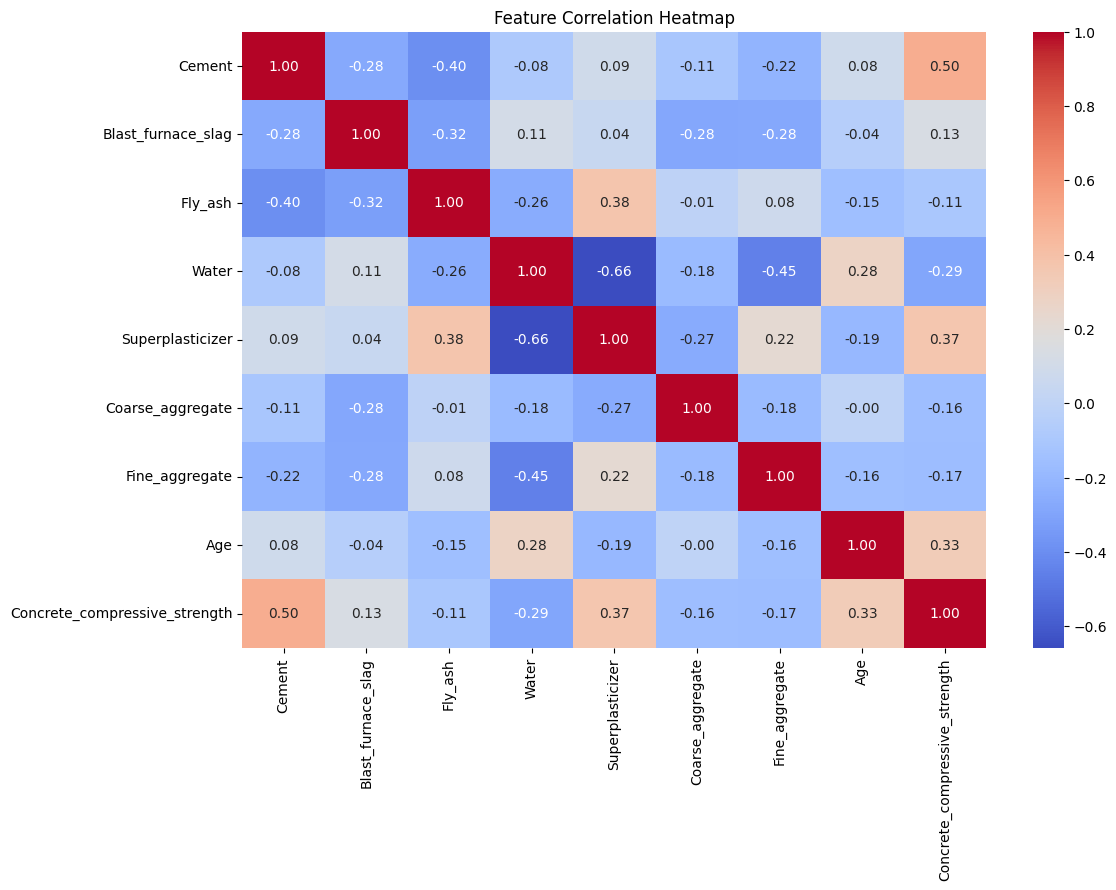

In [11]:
corr_matrix = raw_data.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

Cement, curing age, and superplasticizer show clear positive relationships with strength, meaning higher values generally lead to stronger concrete. Water shows a negative relationship, confirming that too much water reduces strength. Most ingredients are not strongly correlated with each other, which means each feature contributes unique information. Overall, the plot confirms known concrete behavior and supports the use of advanced models that can capture complex interactions between ingredients.

## Strength vs Curing Age:  
Shows how concrete compressive strength develops over time. It helps understand the time-dependent nature of strength gain and the importance of curing age in concrete design.



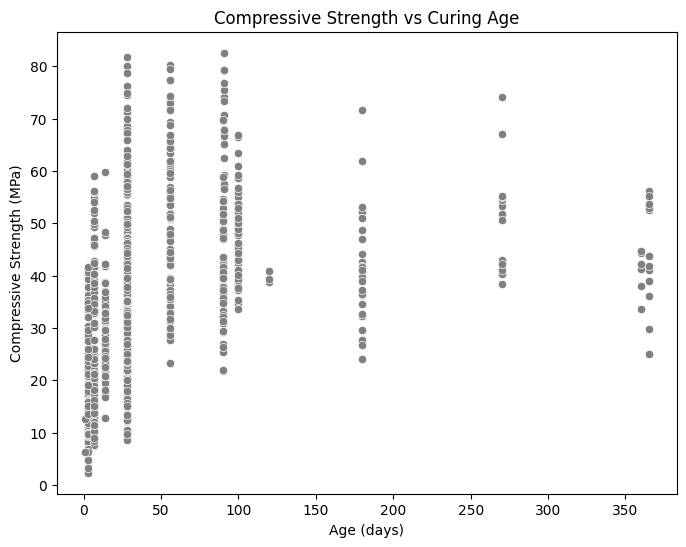

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=raw_data, x='Age', y='Concrete_compressive_strength', color='gray')
plt.title("Compressive Strength vs Curing Age")
plt.xlabel("Age (days)")
plt.ylabel("Compressive Strength (MPa)")
plt.show()

Strength grows very quickly at early ages and then increases more slowly as time passes, which is normal behavior of concrete. The vertical groups of points appear because strength is measured at specific standard ages (like 7, 14, and 28 days). At the same age, strength can vary a lot due to differences in mix ingredients, showing that age alone is not enough to predict strength. The plot confirms that both curing time and mix design together control concrete strength

## Strength Distribution by Material Components:  
These violin plots show how compressive strength varies across different ranges of each material component. The median and quartiles are shown inside the violins, highlighting trends, spread, and the effect of each component on strength.




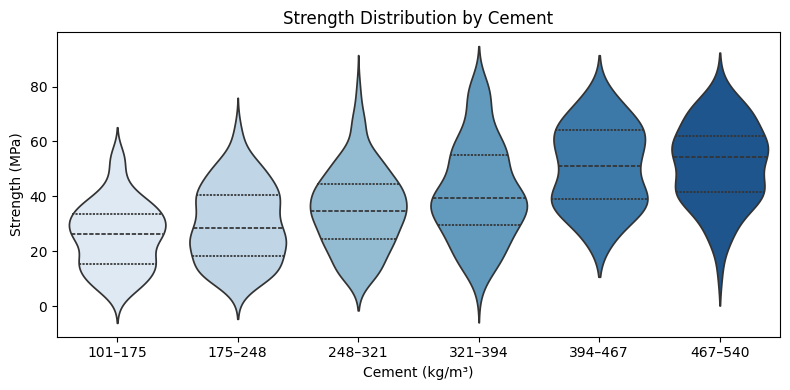

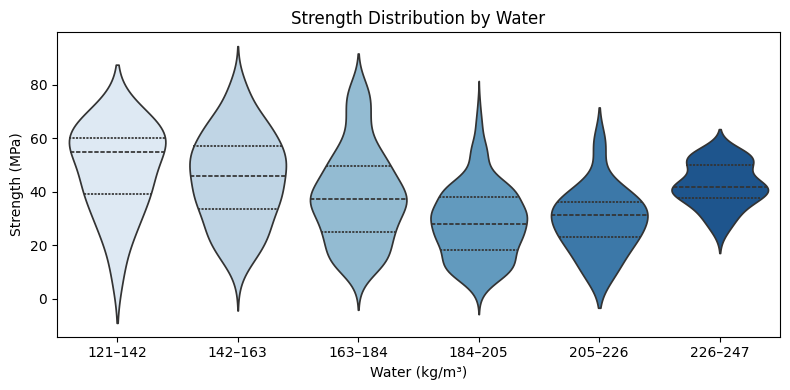

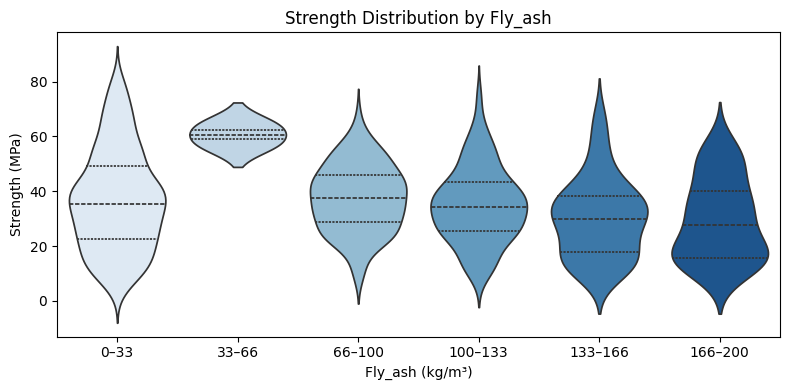

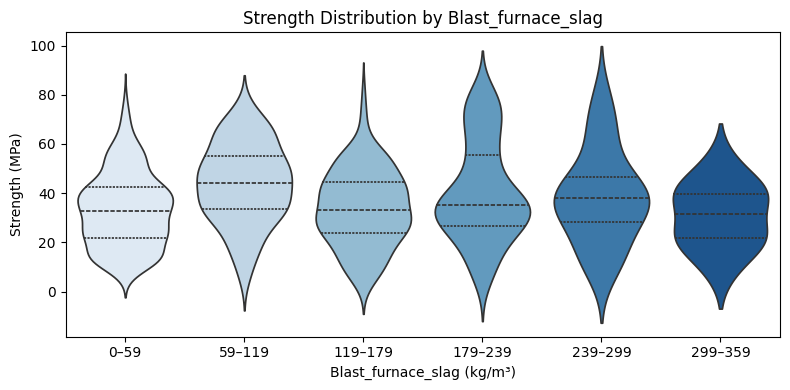

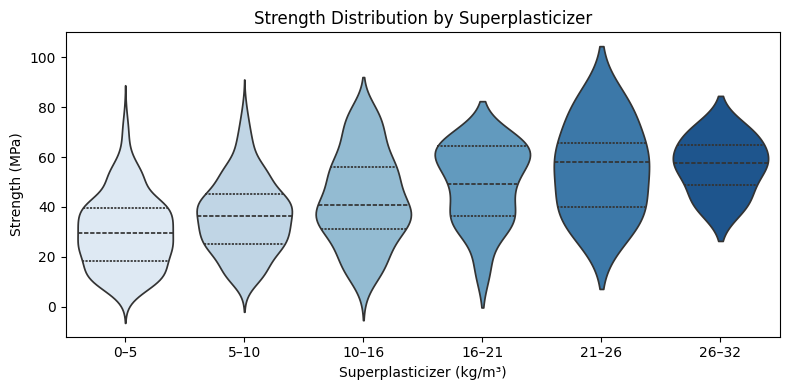

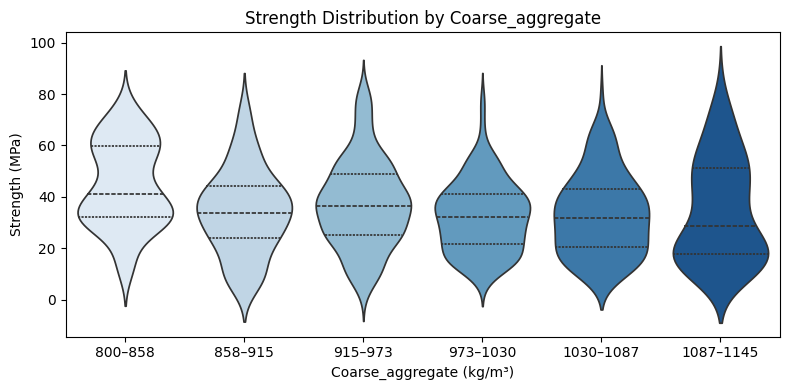

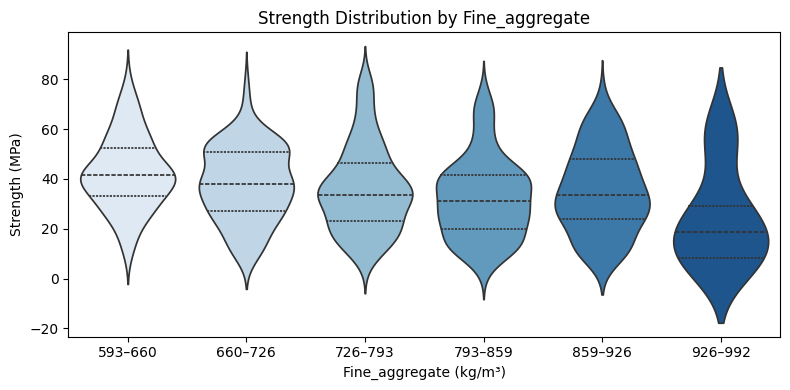

In [13]:
# Features to plot
features = ['Cement', 'Water', 'Fly_ash', 'Blast_furnace_slag',
            'Superplasticizer', 'Coarse_aggregate', 'Fine_aggregate']

# Loop through features
for feature in features:
    bins = pd.cut(raw_data[feature], bins=6)

    plt.figure(figsize=(8,4))
    ax = sns.violinplot(
        x=bins,
        y=raw_data['Concrete_compressive_strength'],
        hue=bins,
        palette='Blues',
        inner='quartile'  # Shows median & quartiles
    )

    # Remove legend if present
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    # Fix x-axis labels cleanly
    ax.set_xticks(range(len(bins.cat.categories)))  # Tick positions
    bin_labels = [f"{int(interval.left)}–{int(interval.right)}" for interval in bins.cat.categories]
    ax.set_xticklabels(bin_labels, fontsize=10)

    # Titles and labels
    plt.title(f"Strength Distribution by {feature}", fontsize=12)
    plt.xlabel(f"{feature} (kg/m³)", fontsize=10)
    plt.ylabel("Strength (MPa)", fontsize=10)

    plt.tight_layout()
    plt.show()

Wider parts mean more samples have similar strength, while taller shapes show more variation. Strength clearly increases with higher cement and decreases with more water, confirming basic concrete behavior. Additives like fly ash, slag, and superplasticizer help boost strength, especially at higher amounts, while aggregates have a smaller effect. The plots show that cement and water are the main controls of strength, and ingredients often work together rather than independently

## Water-to-Cement Ratio vs Strength (Density Plot):  
This KDE density plot visualizes the relationship between the water-to-cement ratio and concrete strength. Darker regions show where most data points lie, helping identify the optimal water/cement ratio for higher strength.

The water-to-cement ratio is a key physics principle in concrete design:  
- **Lower ratio → higher strength** (less porosity, denser matrix)  
- **Higher ratio → lower strength** (more voids, weaker structure)


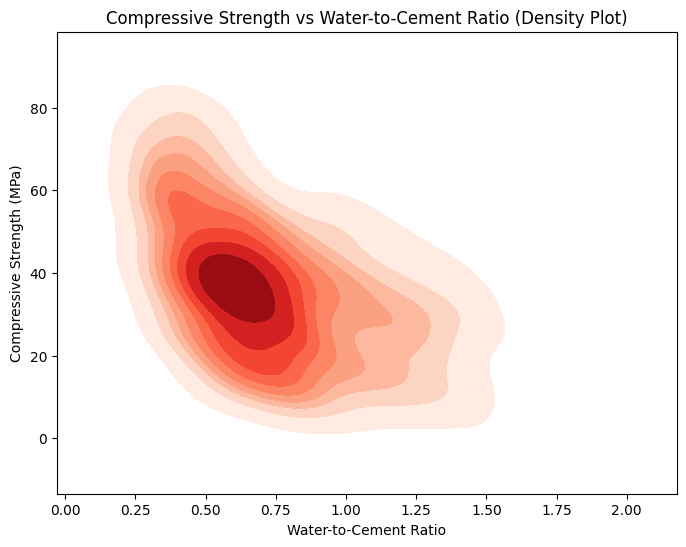

In [14]:
# Create Water-to-Cement ratio
raw_data['Water_Cement_Ratio'] = raw_data['Water'] / raw_data['Cement']
plt.figure(figsize=(8,6))
sns.kdeplot(
    data=raw_data,
    x='Water_Cement_Ratio',
    y='Concrete_compressive_strength',
    fill=True,
    cmap='Reds',
    thresh=0.05
)
plt.title("Compressive Strength vs Water-to-Cement Ratio (Density Plot)")
plt.xlabel("Water-to-Cement Ratio")
plt.ylabel("Compressive Strength (MPa)")
plt.show()

The water-to-cement ratio affects concrete strength, following Abrams’ Law. Low W/C ratios give higher strength (dense, strong concrete), while high W/C ratios produce weaker, porous mixes. The vertical spread at a single W/C ratio reflects the influence of curing age and additives, meaning W/C alone doesn’t fully determine strength. Most concrete in the dataset falls in the standard range (0.4–0.6 W/C).

## Curing Age vs Strength

Concrete gains strength over time due to **hydration of cement**. Early-age strength increases rapidly, while later-age gains are slower.  

Plotting strength vs age helps visualize this time-dependent behavior.


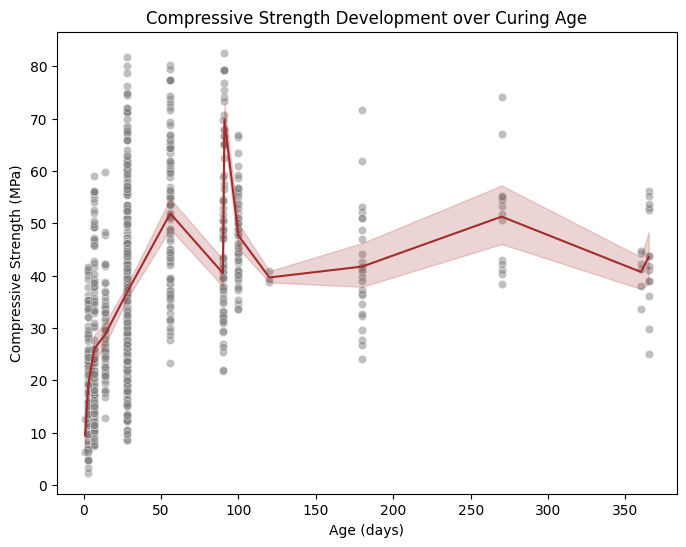

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=raw_data,
    x='Age',
    y='Concrete_compressive_strength',
    color='gray',
    alpha=0.5
)
sns.lineplot(
    data=raw_data,
    x='Age',
    y='Concrete_compressive_strength',
    color='brown'
)
plt.title("Compressive Strength Development over Curing Age")
plt.xlabel("Age (days)")
plt.ylabel("Compressive Strength (MPa)")
plt.show()

Strength grows quickly in the first 28 days (active hydration) and then slows down (plateau phase). The brown line shows the average trend, while the gray dots reveal variation due to mix differences—Age alone doesn’t determine exact strength. Most data is for standard ages (7, 14, 28 days), so the model will predict these well but may be less accurate for very old concrete. A log transformation of Age can help models capture this non-linear growth.

## Coarse and Fine Aggregates vs Strength:  
Aggregates are granular materials used in concrete:  
- **Coarse aggregate**: larger particles (gravel, crushed stone) that provide structural skeleton and improve load-bearing capacity.  
- **Fine aggregate**: smaller particles (sand) that fill voids and improve workability, but excessive amounts can reduce strength.  

Aggregates affect density, load distribution, and porosity:  
- Higher coarse aggregate can improve strength.  
- Excessive fine aggregate may reduce strength.  






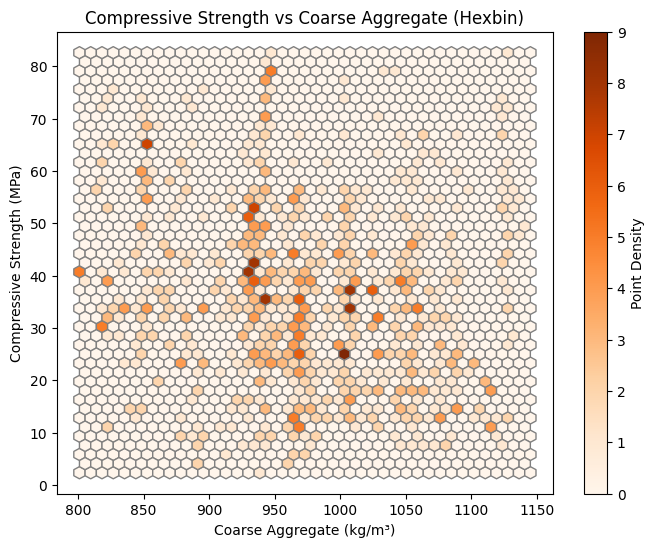

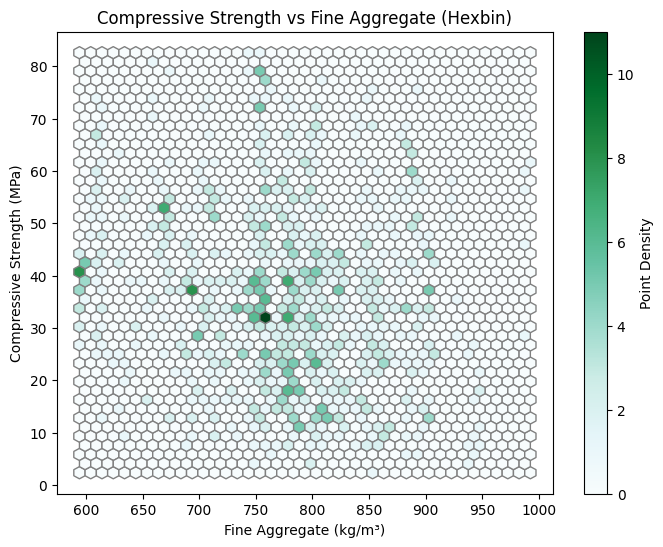

In [16]:
plt.figure(figsize=(8,6))
plt.hexbin(
    raw_data['Coarse_aggregate'],
    raw_data['Concrete_compressive_strength'],
    gridsize=40,
    cmap='Oranges',
    edgecolors='grey'
)
plt.colorbar(label='Point Density')
plt.title("Compressive Strength vs Coarse Aggregate (Hexbin)")
plt.xlabel("Coarse Aggregate (kg/m³)")
plt.ylabel("Compressive Strength (MPa)")
plt.show()


plt.figure(figsize=(8,6))
plt.hexbin(
    raw_data['Fine_aggregate'],
    raw_data['Concrete_compressive_strength'],
    gridsize=40,
    cmap='BuGn',
    edgecolors='grey'
)
plt.colorbar(label='Point Density')
plt.title("Compressive Strength vs Fine Aggregate (Hexbin)")
plt.xlabel("Fine Aggregate (kg/m³)")
plt.ylabel("Compressive Strength (MPa)")
plt.show()

Coarse aggregate forms the structural skeleton, while fine aggregate fills the voids—both are important for mix balance but have less direct impact on strength than Cement. Darker hexagons show common industry-standard dosages. These features help the model understand aggregate distribution but won’t strongly predict strength on their own.

## Water-to-Cement Ratio vs Strength Colored by Age:  
This plot combines two key physics concepts in concrete:  

- **Water-to-Cement (W/C) ratio**: Lower ratios generally increase strength by reducing porosity. Porosity is the fraction of void space (air or water-filled gaps) within a material.

In concrete:

High porosity → more empty spaces → weaker, less dense concrete.

Low porosity → fewer voids → stronger, denser concrete.

So when we say lower Water-to-Cement ratio reduces porosity, it means the mix has fewer gaps, making the concrete stronger.  
- **Curing Age**: The time the concrete is allowed to harden and hydrate. Strength increases with curing age because hydration reactions continue over time, making the material denser and stronger.  





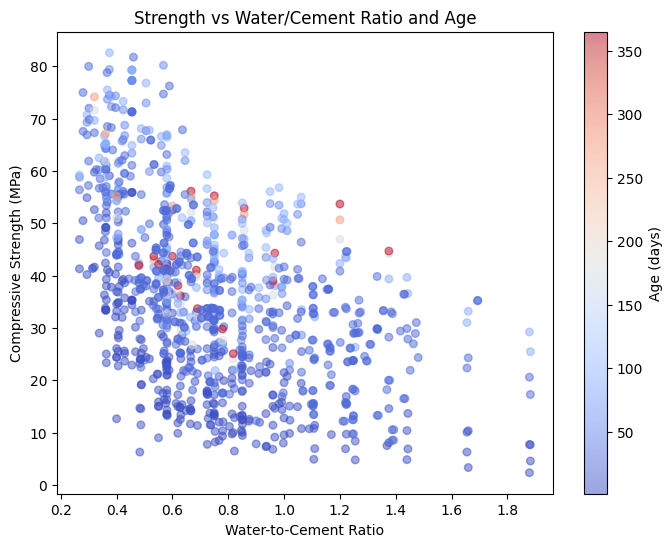

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(
    raw_data['Water_Cement_Ratio'],
    raw_data['Concrete_compressive_strength'],  # fixed column name
    c=raw_data['Age'],
    cmap='coolwarm',
    alpha=0.5,
    s=30
)
plt.colorbar(label='Age (days)')
plt.title("Strength vs Water/Cement Ratio and Age")
plt.xlabel("Water-to-Cement Ratio")
plt.ylabel("Compressive Strength (MPa)")
plt.show()

The vertical color stripes show how strength grows over time for each mix, highlighting that Age alone isn’t enough—both mix and time matter. This confirms that Water_Cement_Ratio is a key feature for predicting strength.

### **EDA Summary**

Through exploratory data analysis, we gained a clear understanding of the dataset and how different features influence concrete strength:

- **Distributions**: Most features have reasonable spreads. Additives like Slag, Fly Ash, and Superplasticizer are often zero, while Age is right-skewed. Strength varies widely, providing a solid target for modeling.

- **Correlations**: Cement, Age, and Superplasticizer positively impact strength. Water negatively affects strength. There are no highly redundant features.

- **Feature Relationships**:
  - Higher Cement and lower Water generally increase strength.
  - Low Water-to-Cement ratio combined with adequate curing age leads to stronger concrete.
  - Aggregates (Coarse and Fine) mainly provide structure, with moderate effect on strength.

- **Non-linear Trends**: Strength grows rapidly in the first 28 days and slows afterward. This non-linear behavior highlights the importance of non-linear modeling and feature engineering.

- **Key Insights for Modeling**:
  - Critical features: Cement, Water, Age, Superplasticizer.
  - Create Water-to-Cement ratio as a derived feature.
  - Consider interactions, e.g., Age × Water-to-Cement ratio.
  - Non-linear models like Random Forest or Gradient Boosting are likely to perform best.
